# AE2- RNN
- This is the demostration for using RNN-Bidirectional LSTM on discerning five classes of GBV in tweets. 
### ALL cells has been ran

### Import dataset

In [1]:
import pandas as pd

GBV_train = 'archive/Train.csv'

read_GBV_train = pd.read_csv(GBV_train, sep=',')

#drop column Tweet_ID
read_GBV_train.drop(columns=['Tweet_ID'], inplace=True)

print(read_GBV_train.head())


                                               tweet             type
0  Had a dream i got raped last night. By a guy i...  sexual_violence
1  he thought the word raped means sex and told m...  sexual_violence
2  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...  sexual_violence
3  I was sexually abused for 3 years at age 4 to ...  sexual_violence
4  Chessy Prout can do better by telling the trut...  sexual_violence


### Visualise Data 

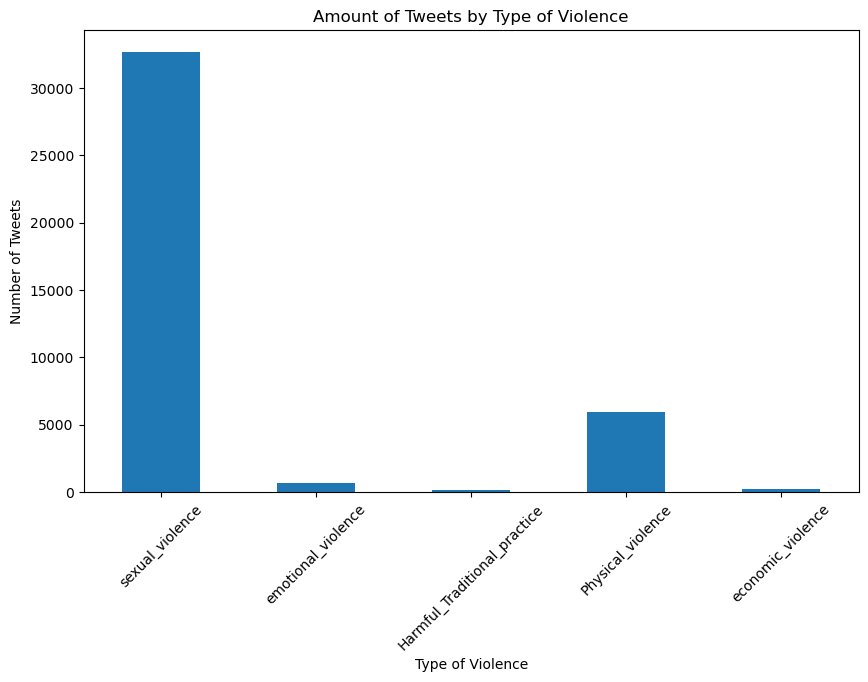

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


#Count the occurrences of each type of violence
violence_counts = read_GBV_train['type'].value_counts()

specified_violence_counts = violence_counts.loc[
    ['sexual_violence', 'emotional_violence', 'Harmful_Traditional_practice', 'Physical_violence', 'economic_violence']
]

#Create the bar chart
plt.figure(figsize=(10, 6)) 
specified_violence_counts.plot(kind='bar')

#Setting the title and labels
plt.title('Amount of Tweets by Type of Violence')
plt.xlabel('Type of Violence')
plt.ylabel('Number of Tweets')

plt.xticks(rotation=45)  
plt.show()


In [3]:
#Print the counts for better understanding
print("Sexual Violence:", specified_violence_counts['sexual_violence'])
print("Emotional Violence:", specified_violence_counts['emotional_violence'])
print("Harmful Traditional Practice:", specified_violence_counts['Harmful_Traditional_practice'])
print("Physical Violence:", specified_violence_counts['Physical_violence'])
print("Economic Violence:", specified_violence_counts['economic_violence'])


Sexual Violence: 32648
Emotional Violence: 651
Harmful Traditional Practice: 188
Physical Violence: 5946
Economic Violence: 217


In [4]:
### text preprocessing 

def clean_and_convert_text(raw_text):
    import unicodedata
    import nltk
    import string
    import contractions
    
    #Ensure nltk resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    
    #Convert UTF characters
    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'").replace('\u201C', "`").replace('\u201D', "`").replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore')
        return text.decode('ascii')
    
    UTF_text = convert_utf(raw_text)
    normalised_text = UTF_text.lower()
    words = nltk.word_tokenize(normalised_text)
    
    #Remove punctuations and expand contractions
    words = [contractions.fix(word) for word in words if word not in string.punctuation]
    
    #Remove numbers and specific symbols
    words = [word for word in words if not word.isdigit() and word not in ['---', '...', '***']]
    
    #Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    return words


In [5]:
import pandas as pd
import unicodedata
import string
import nltk
import contractions


In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/jen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import pandas as pd #provides data structures for efficiently storing and analyzing data
import matplotlib.pyplot as plt #visualization library/  provides a simple interface for creating various types of plots and charts.
import seaborn as sns #It provides a high-level interface for creating aesthetically pleasing and informative statistical graphics.
from sklearn.feature_extraction.text import CountVectorizer #It is used to convert a collection of text documents into a matrix of token counts.
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a set of English stop words provided by Scikit-learn
from sklearn.naive_bayes import MultinomialNB #a classification algorithm provided by Scikit-learn, used for text classification tasks 
from sklearn.metrics import accuracy_score #calculate the accuracy of a classification model's predictions.
from sklearn.linear_model import LogisticRegression #a classification algorithm
from sklearn.feature_extraction.text import TfidfVectorizer#perform text vectorising
from sklearn.model_selection import train_test_split as split#for training classifier model
from sklearn.metrics import classification_report#produce classification report

## Text preproccessing

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import unicodedata
import nltk
import string
import contractions

#using the reprocessing function directly returning a list of preprocessed words
def clean_and_convert_text(raw_text):
    # Convert UTF characters
    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'").replace('\u201C', "`").replace('\u201D', "`").replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore')
        return text.decode('ascii')
    
    UTF_text = convert_utf(raw_text)
    normalised_text = UTF_text.lower()
    words = nltk.word_tokenize(normalised_text)
    
    #Remove punctuations and expand contractions
    words = [contractions.fix(word) for word in words if word not in string.punctuation]
    
    #Remove numbers and specific symbols
    words = [word for word in words if not word.isdigit() and word not in ['---', '...', '***']]
    
    #Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    return words


## Apply text preprocess function

In [9]:
#Load the dataset
train_data_path = "archive/Train.csv"
train_data = pd.read_csv(train_data_path)

#Apply preprocessing 
train_data['cleaned_text'] = train_data['tweet'].apply(clean_and_convert_text)


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

#calculate the column processed_text
texts = train_data['cleaned_text'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

#total number of unique words
unique_words = len(tokenizer.word_index)

print(f"Total number of unique words: {unique_words}")


Total number of unique words: 41987


### Initialise:
Reference from NLP course: rnn_sentiment_analysis (1).ipynb

In [11]:
import re
import tensorflow as tf

max_features = 4000 #therefore set at 4000 for a dataset size at 39,650 tweets and with unique words of 41987, is reasonable.from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_data['cleaned_text'].values)

### Convert text into sequence 

In [12]:
X = tokenizer.texts_to_sequences(train_data['cleaned_text'].values)


In [13]:
#padding the tokensied sequebces to maintain the same length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [14]:
X.shape

(39650, 46)

In [15]:
train_data['cleaned_text'].head()

0    [dream, got, raped, last, night, guy, work, ac...
1    [thought, word, raped, means, sex, told, saw, ...
2    [talking, raped, men, molested, jail, nother, ...
3    [sexually, abused, years, age, 7., one, believ...
4    [chessy, prout, better, telling, truth, sellin...
Name: cleaned_text, dtype: object

## Create Model
Reference from NLP course: rnn_sentiment_analysis (1).ipynb

*RNN design rationale: *
1. **max_features**:
   - the dataset contains 39,650 tweets
   - with unique words of 41987
   - this is a relatively smaller dataset

2. **Model Architecture Parameters**:
   - **embed_dim**: The size of the embedding vector. This defines the size of the space into which words will be embedded. If it's too big and the dataset is not large enough, it can lead to overfitting.
   - **lstm_out**: The number of units in the LSTM layer. This captures information across long sequences. If the dataset is not big enough, it can lead to overfitting.
   - The dropout rate in **SpatialDropout1D**: This helps in reducing overfitting and ensures the model does not rely too much on single words.
   - **Dropout**: It prevents overfitting.
   - **Recurrent Dropout**: High recurrent dropout rates can significantly slow down training.

7. **Training Parameters**:
   - **epochs**: The number of times the model will work through the entire training dataset. If the model is overfitting, you can decrease the number of epochs.
   - **Batch size**: The number of samples that will be propagated through the network before updating model parameters. A larger size can lead to faster training times but might lead to slow convergence.
   - **Verbose**: The amount of information printed. This is useful for debugging.

8. **Model Layers**:
   - Consider adding or removing layers (e.g., more LSTM layers, Bidirectional LSTM layers, Dense layers).
   - Experiment with different layer configurations and additional regularization techniques (e.g., BatchNormalization, L1/L2 regularization).

9. **Balanced Dataset**
- this is a highly imbalanced dataset
Sexual Violence: 32648
Emotional Violence: 651
Harmful Traditional Practice: 188
Physical Violence: 5946
Economic Violence: 217

In [16]:
embed_dim = 256
lstm_out = 196

#Create the RNN model with LSTM cells
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, recurrent_dropout=0.2)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))#connect 5 classes 
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 256)           1024000   
                                                                 
 spatial_dropout1d (Spatial  (None, 46, 256)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 392)               710304    
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 1965      
                                                                 
Total params: 1736269 (6.62 MB)
Trainable params: 1736269 (6.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
import numpy as np
! pip3 install sklearn
from sklearn.model_selection import train_test_split

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [18]:
import pandas as pd
import numpy as np

#Create a one-hot encoded representation of the output labels, ref.[1]
Y = pd.get_dummies(train_data['type'])

#Y DataFrame now has one column for each class >>Y's columns are: 'sexual_violence', 'emotional_violence', 'Harmful_Traditional_practice', 'Physical_violence', 'economic_violence'

y_labels = Y.columns.tolist()

#'y_labels' will be a list of the classes:>>> ['sexual_violence', 'emotional_violence', 'Harmful_Traditional_practice', 'Physical_violence', 'economic_violence']

#Y can be used as the output labels for training your RNN model.


In [19]:
Y = Y.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(26565, 46) (26565, 5)
(13085, 46) (13085, 5)


In [20]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, verbose=2)

Epoch 1/5
208/208 - 70s - loss: 0.1801 - accuracy: 0.9508 - 70s/epoch - 335ms/step
Epoch 2/5
208/208 - 79s - loss: 0.0192 - accuracy: 0.9933 - 79s/epoch - 382ms/step
Epoch 3/5
208/208 - 77s - loss: 0.0057 - accuracy: 0.9988 - 77s/epoch - 372ms/step
Epoch 4/5
208/208 - 77s - loss: 0.0047 - accuracy: 0.9990 - 77s/epoch - 372ms/step
Epoch 5/5
208/208 - 78s - loss: 5.1793e-04 - accuracy: 1.0000 - 78s/epoch - 374ms/step


## Accuracy scores

In [21]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

205/205 - 11s - loss: 0.0075 - accuracy: 0.9982 - 11s/epoch - 53ms/step
score: 0.01
acc: 1.00


In [22]:
#list all data in history, for plotting perpose below ref.[2]
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


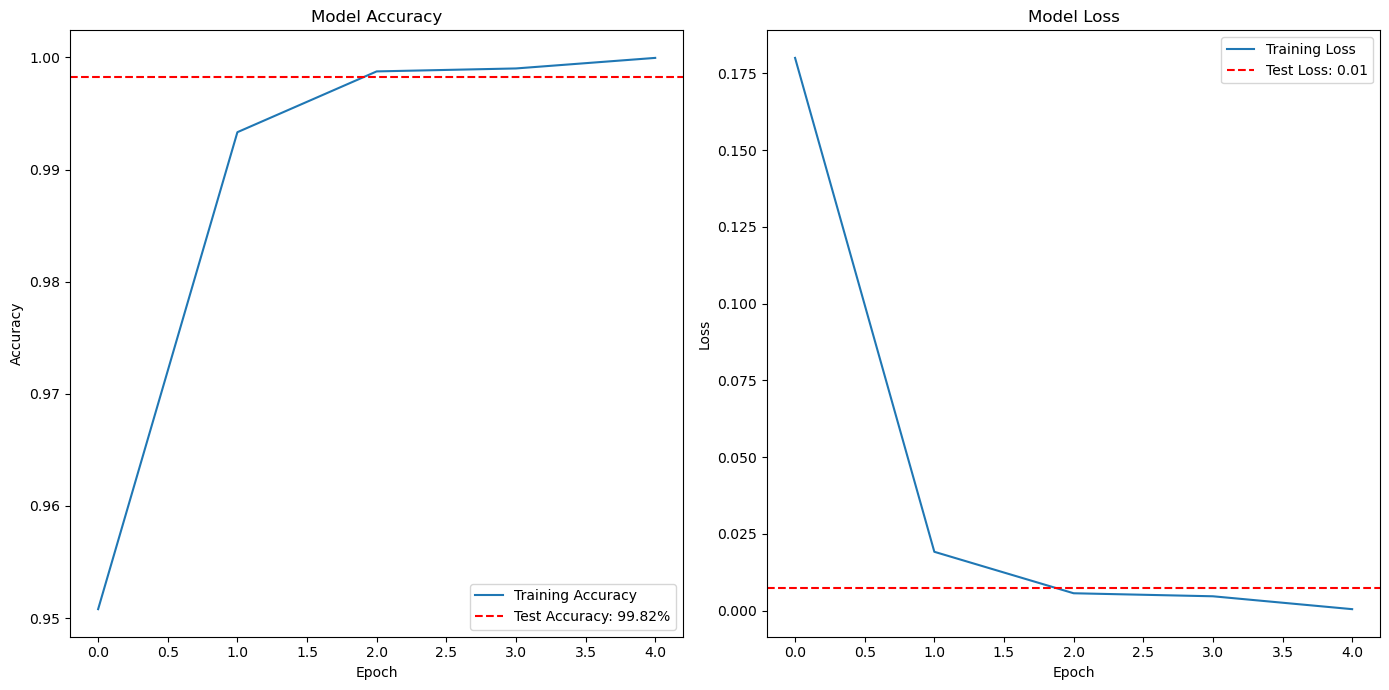

In [23]:
import matplotlib.pyplot as plt

#'score'= test loss and `acc` = test accuracy

#Plotting training and validation accuracy and loss, including test accuracy and loss ref.[3]
plt.figure(figsize=(14, 7))

#Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:  # Check if validation accuracy exists
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

#Annotating the plot with the test accuracy
plt.axhline(y=acc, color='r', linestyle='--', label=f'Test Accuracy: {acc*100:.2f}%')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

#Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:  # Check if validation loss exists
    plt.plot(history.history['val_loss'], label='Validation Loss')

#Annotating the plot with the test loss
plt.axhline(y=score, color='r', linestyle='--', label=f'Test Loss: {score:.2f}')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


## Classification Report: 

In [24]:
#ref.[6]
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split=0.3, epochs=5, verbose=2)

from sklearn.metrics import classification_report
import numpy as np

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=y_labels)

print(report)


Epoch 1/5
582/582 - 138s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0288 - val_accuracy: 0.9952 - 138s/epoch - 237ms/step
Epoch 2/5
582/582 - 144s - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0062 - val_accuracy: 0.9991 - 144s/epoch - 248ms/step
Epoch 3/5
582/582 - 147s - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0155 - val_accuracy: 0.9967 - 147s/epoch - 252ms/step
Epoch 4/5
582/582 - 148s - loss: 3.3316e-04 - accuracy: 0.9999 - val_loss: 0.0030 - val_accuracy: 0.9995 - 148s/epoch - 254ms/step
Epoch 5/5
582/582 - 146s - loss: 3.3237e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9995 - 146s/epoch - 251ms/step
409/409 [==============================] - 17s 41ms/step
                              precision    recall  f1-score   support

Harmful_Traditional_practice       0.98      0.93      0.96        70
           Physical_violence       1.00      1.00      1.00      1975
           economic_violence       0.95      0.96      0.95        75
          emotional

## Testing unlabelled files 

In [25]:
import pandas as pd

GBV_test = 'archive/Test.csv'

read_GBV_test = pd.read_csv(GBV_test, sep=',')

#drop column Tweet_ID
read_GBV_test.drop(columns=['Tweet_ID'], inplace=True)

print(read_GBV_test.head())


                                               tweet
0  because he was my boyfriend, and if I said no,...
1  lol no, I'm telling you it's not legal. It's l...
2  Somalia's semi-autonomous Puntland region has ...
3  University of Cape Coast students being robbed...
4  "Somebody came up behind him and stabbed him i...


In [26]:
#Load the dataset
test_data_path = "archive/Test.csv"
test_data = pd.read_csv(test_data_path)

#Apply preprocessing 
test_data['cleaned_test_txt'] = test_data['tweet'].apply(clean_and_convert_text)

test_data.head()


,Tweet_ID,tweet,cleaned_test_txt
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,...","[boyfriend, said, would, get, mad, hated, sex,..."
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l...","[lol, 'm, telling, 's, legal, 's, literally, c..."
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...,"[somalia, 's, semi-autonomous, puntland, regio..."
3,ID_00G9OSKZ,University of Cape Coast students being robbed...,"[university, cape, coast, students, robbed, ra..."
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i...","[``, somebody, came, behind, stabbed, back, re..."


In [27]:
import re
import tensorflow as tf

max_features = 4000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(test_data['cleaned_test_txt'].values)

X = tokenizer.texts_to_sequences(test_data['cleaned_test_txt'].values)

#and lastly, pad the tokenized sequences to maintain the same length across all the input sequences.
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [28]:
predictions = model.predict(X_test)#ref [4]


409/409 [==============================] - 16s 38ms/step


In [29]:
import numpy as np

#Convert prediction probabilities to class indices ref.[5]
predicted_class_indices = np.argmax(predictions, axis=1)


In [30]:
# a list of `y_labels` mapping indices to class names
predicted_class_labels = [y_labels[idx] for idx in predicted_class_indices] 


In [33]:
import pandas as pd

# Creating a new DataFrame with the predicted labels
results_df = pd.DataFrame({
    'PredictedLabel': predicted_class_labels
})

#Save as a CSV file
results_df.to_csv('predicted_labels_RNN.csv', index=False)


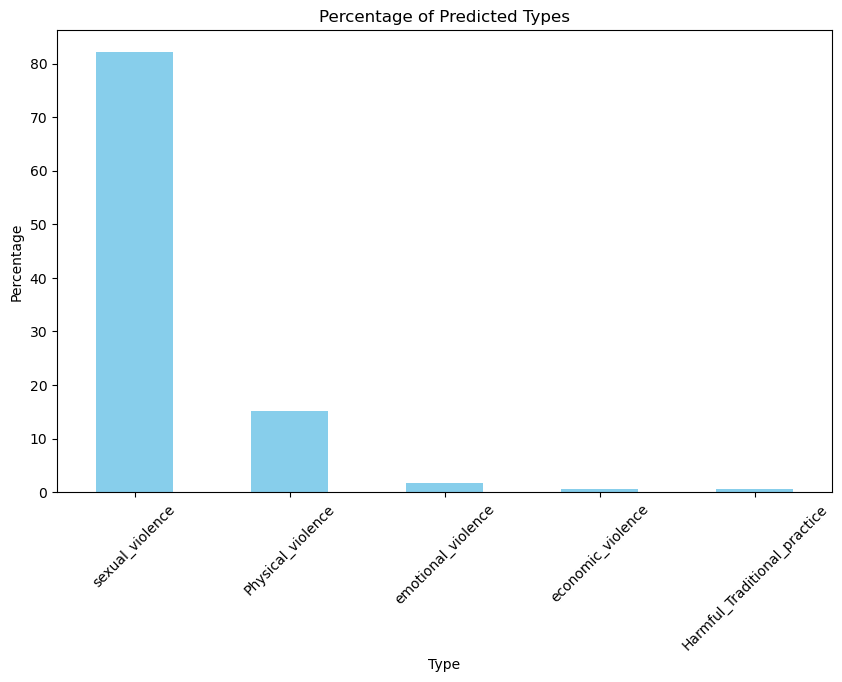

Percentage of each type:
PredictedLabel
sexual_violence                 82.132212
Physical_violence               15.055407
emotional_violence               1.727169
economic_violence                0.580818
Harmful_Traditional_practice     0.504394
Name: count, dtype: float64


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

test_data_with_predictions = pd.read_csv("predicted_labels_RNN.csv")

#Count the occurrences 
type_counts = test_data_with_predictions['PredictedLabel'].value_counts()

#Calculate the percentage 
total_predictions = type_counts.sum()
type_percentages = (type_counts / total_predictions) * 100

#Plot the bar chart
plt.figure(figsize=(10, 6))
type_percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Predicted Types')
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

print("Percentage of each type:")
print(type_percentages)
